In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import transforms
import torch.utils.data as datautils

import pandas as pd
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

cuda = torch.cuda.is_available()

## Preparing for data

In [19]:
from google.colab import files
print('Upload kaggle.json')
files.upload()

!cp kaggle.json /root/.kaggle/
!kaggle competitions download -c digit-recognizer
!ls

Upload kaggle.json


Saving kaggle.json to kaggle.json
 81% 59.0M/73.2M [00:00<00:00, 171MB/s]
100% 73.2M/73.2M [00:00<00:00, 199MB/s]
 78% 38.0M/48.8M [00:00<00:00, 169MB/s]
100% 48.8M/48.8M [00:00<00:00, 183MB/s]
  0% 0.00/235k [00:00<?, ?B/s]
100% 235k/235k [00:00<00:00, 24.6MB/s]
kaggle.json  sample_data  sample_submission.csv  test.csv  train.csv


In [22]:
train = pd.read_csv('./train.csv')
train.head() 

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,...,pixel744,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [0]:
image_numpy = train.loc[:, train.columns != 'label'].values / 255 # normalization
label_numpy = train.label.values

In [0]:
image_train, image_test, label_train, label_test = train_test_split(image_numpy, label_numpy, test_size = 0.2, random_state = 42)

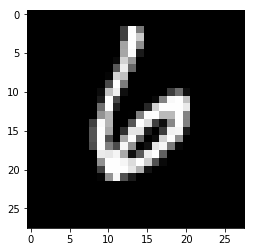

In [40]:
plt.imshow(image_train[0].reshape(28, 28), cmap='gray')

In [0]:
image_train = torch.from_numpy(image_train).float()
label_train = torch.from_numpy(label_train).type(torch.LongTensor)

image_test = torch.from_numpy(image_test).float()
label_test = torch.from_numpy(label_test).type(torch.LongTensor)

In [0]:
train_set = datautils.TensorDataset(image_train, label_train)
test_set = datautils.TensorDataset(image_test, label_test)

train_loader = datautils.DataLoader(train_set, batch_size = 64, shuffle = False)
test_loader = datautils.DataLoader(test_set, batch_size = 64, shuffle = False)                       

## Building model

In [0]:
class LogisticRegression(nn.Module):
    def __init__(self, in_size, out_size):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(in_size, out_size)
        
        if cuda:
            self.linear = self.linear.cuda()
        
    def forward(self, x):
        out = self.linear(x)
        return x

In [0]:
in_size = 28 * 28
out_size = 1

net = LogisticRegression(in_size, out_size)
get_loss = nn.CrossEntropyLoss()
learning_rate = 0.01
optimizer = optim.Adam(net.parameters(), lr = learning_rate)

In [57]:
from torch.autograd import Variable

batch_size = 64
n_iter = 100
n_epoch = int(n_iter * (image_train.shape[0] / batch_size))
loss_graph = []

for epoch in range(n_epoch):
    for x, label in train_loader:
        x = Variable(x, requires_grad = True)
        
        if cuda:
            x = x.cuda()
            label = label.cuda()
        
        optimizer.zero_grad()
        out = net(x)
        loss = get_loss(out, label)
        loss.backward()
        optimizer.step()
        loss_graph.append(loss.data)

KeyboardInterrupt: ignored